 # BBM418 Fourth Assignment - Report Ready Version

 # Name: Ahmet Oğuzhan Kökülü

 # Student ID: 2220356053

In [3]:
import re
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.models import resnet18, ResNet18_Weights
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torchvision.ops as ops 

# Install torchmetrics if missing
try:
    from torchmetrics.detection.mean_ap import MeanAveragePrecision
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Set Seeds for Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)


 ## 1. Dataset & Augmentation

In [4]:
class PennFudanDataset(Dataset):
    def __init__(self, root_dir, split='train', transforms=None, augment=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.augment = augment 
        
        split_path = os.path.join(root_dir, "splits/"+split+".txt")
        with open(split_path, "r") as split_file:
            content = split_file.read()
            self.images = content.splitlines() if "\n" in content else content.split()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx].split(".")[0]
        image_path = os.path.join(self.root_dir, "Pedestrian/"+img_name+".png")
        annotation_path = os.path.join(self.root_dir, "Pedestrian/"+img_name+".txt")

        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        bounding_boxes = []
        with open(annotation_path) as ann:
            for line in ann:
                if "Bounding box" in line:
                    bounding_box_coor = re.findall(r'\d+', line.split(":")[1])
                    bounding_boxes.append([int(x) for x in bounding_box_coor])

        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)

        # --- MANUAL AUGMENTATION ---
        if self.augment:
            # 1. Random Scale/Crop (Zoom)
            if random.random() > 0.5:
                scale = random.uniform(0.6, 1.0)
                new_w, new_h = int(width * scale), int(height * scale)
                x_off = random.randint(0, width - new_w)
                y_off = random.randint(0, height - new_h)
                
                image = image.crop((x_off, y_off, x_off + new_w, y_off + new_h))
                
                if len(bounding_boxes) > 0:
                    bounding_boxes[:, 0] -= x_off
                    bounding_boxes[:, 1] -= y_off
                    bounding_boxes[:, 2] -= x_off
                    bounding_boxes[:, 3] -= y_off
                    bounding_boxes[:, 0].clamp_(0, new_w)
                    bounding_boxes[:, 1].clamp_(0, new_h)
                    bounding_boxes[:, 2].clamp_(0, new_w)
                    bounding_boxes[:, 3].clamp_(0, new_h)
                    
                    keep = (bounding_boxes[:, 2] > bounding_boxes[:, 0] + 5) & \
                           (bounding_boxes[:, 3] > bounding_boxes[:, 1] + 5)
                    bounding_boxes = bounding_boxes[keep]
                
                width, height = new_w, new_h

            # 2. Horizontal Flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                if len(bounding_boxes) > 0:
                    new_xmin = width - bounding_boxes[:, 2]
                    new_xmax = width - bounding_boxes[:, 0]
                    bounding_boxes[:, 0] = new_xmin
                    bounding_boxes[:, 2] = new_xmax

        coordinates = []
        for box in bounding_boxes:
            xmin, ymin, xmax, ymax = box
            box_w = xmax - xmin
            box_h = ymax - ymin
            cx = xmin + box_w / 2
            cy = ymin + box_h / 2
            coordinates.append([cx/width, cy/height, box_w/width, box_h/height])

        box_tensor = torch.as_tensor(coordinates, dtype=torch.float32)
        if len(box_tensor) == 0:
            box_tensor = torch.zeros((0, 4), dtype=torch.float32)

        target = {}
        target["boxes"] = box_tensor
        target["labels"] = torch.ones(len(coordinates), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["orig_size"] = torch.tensor([height, width]) 

        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, target

stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_transform = T.Compose([
    T.Resize((512, 512)),
    T.RandomApply([T.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.RandomApply([T.GaussianBlur((5, 9))], p=0.5),
    T.ToTensor(),
    T.Normalize(*stats)
])

val_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(*stats)
])

def collat_func(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images)
    return images, targets

root_path = "ignore" 
train_dataset = PennFudanDataset(root_path, split="train", transforms=train_transform, augment=True)
val_dataset = PennFudanDataset(root_path, split="val", transforms=val_transform, augment=False)
test_dataset = PennFudanDataset(root_path, split="test", transforms=val_transform, augment=False)

train_dloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collat_func)
val_dloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collat_func)
test_dloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collat_func)


 ## 2. TinyDETR Model (Magic Fix)

In [5]:
class TinyDETR(nn.Module):
    def __init__(self, num_queries, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
        super().__init__()

        # ResNet18 Backbone
        raw_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Dilation Fix: 16x16 -> 32x32 feature map
        raw_model.layer4[0].conv1.stride = (1, 1)
        raw_model.layer4[0].downsample[0].stride = (1, 1)
        
        self.backbone = nn.Sequential(*list(raw_model.children())[:-2])
        backbone_channels = 512
        
        # Unfreeze weights
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.conv = nn.Conv2d(backbone_channels, hidden_dim, kernel_size=1)
        self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        
        # Initialization
        self.query_pos = nn.Parameter(torch.zeros(num_queries, hidden_dim))
        nn.init.xavier_uniform_(self.query_pos)
        
        self.class_head = nn.Linear(hidden_dim, num_classes+1)
        self.bbox_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)
        )

    # --- MAGIC FIX: Force BN to Eval Mode ---
    def train(self, mode=True):
        super().train(mode)
        if mode:
            self.backbone.train()
            # Freeze BN stats
            for module in self.backbone.modules():
                if isinstance(module, torch.nn.BatchNorm2d):
                    module.eval()

    def encode_position(self, d_model, height, width, device):
        x_pos = torch.arange(width, dtype=torch.float32, device=device)
        y_pos = torch.arange(height, dtype=torch.float32, device=device)
        dim_t = torch.arange(0, d_model//2, 2, dtype=torch.float32, device=device)
        div_term = torch.exp(dim_t * (-torch.log(torch.tensor(10000.0)) / (d_model // 2)))

        poen_x = torch.zeros(width, d_model//2, device=device)
        poen_x[:, 0::2] = torch.sin(x_pos.unsqueeze(1) * div_term)
        poen_x[:, 1::2] = torch.cos(x_pos.unsqueeze(1) * div_term)
        
        poen_y = torch.zeros(height, d_model // 2, device=device)
        poen_y[:, 0::2] = torch.sin(y_pos.unsqueeze(1) * div_term)
        poen_y[:, 1::2] = torch.cos(y_pos.unsqueeze(1) * div_term)

        poen_x = poen_x.unsqueeze(0).repeat(height, 1, 1)
        poen_y = poen_y.unsqueeze(1).repeat(1, width, 1)
        
        poen = torch.cat([poen_x, poen_y], dim=2)
        return poen.permute(2, 0, 1).unsqueeze(0)
        
    def forward(self, x):
        for module in self.backbone.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                module.eval()

        features = self.backbone(x)
        h = self.conv(features) 
        B, C, H, W = h.shape
        pos_enc = self.encode_position(C, H, W, h.device)
        
        src = (h + pos_enc).flatten(2).permute(2, 0, 1)
        query_embed = self.query_pos.unsqueeze(1).repeat(1, B, 1)

        hs = self.transformer(src, query_embed)
        hs = hs.permute(1, 0, 2)
        
        return {'pred_logits': self.class_head(hs), 'pred_boxes': self.bbox_head(hs).sigmoid()}


 ## 3. Matcher & Loss

In [6]:
def box_c_to_xy(x):
    cx, cy, w, h = x.unbind(-1)
    b = [(cx - 0.5 * w), (cy - 0.5 * h), (cx + 0.5 * w), (cy + 0.5 * h)]
    return torch.stack(b, dim=-1)

def generalized_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1]) 
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1]) 
    lt = torch.max(boxes1[:, :2].unsqueeze(1), boxes2[:, :2].unsqueeze(0))
    rb = torch.min(boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:].unsqueeze(0))
    wh = (rb - lt).clamp(min=0) 
    inter = wh[:, :, 0] * wh[:, :, 1] 
    union = area1.unsqueeze(1) + area2.unsqueeze(0) - inter
    iou = inter / union
    lt_c = torch.min(boxes1[:, :2].unsqueeze(1), boxes2[:, :2].unsqueeze(0))
    rb_c = torch.max(boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:].unsqueeze(0))
    wh_c = (rb_c - lt_c).clamp(min=0)
    area_c = wh_c[:, :, 0] * wh_c[:, :, 1]
    return iou - ((area_c - union) / (area_c + 1e-6))

class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=5, cost_giou=2):
        super().__init__()
        self.w_class, self.w_bbox, self.w_giou = cost_class, cost_bbox, cost_giou

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs = outputs["pred_logits"].shape[0]
        indices = []
        for i in range(bs):
            probs = outputs["pred_logits"][i].softmax(-1)
            pred_boxes = outputs["pred_boxes"][i]
            tgt_ids = targets[i]["labels"]
            tgt_boxes = targets[i]["boxes"]
            cost_class = -probs[:, tgt_ids]
            cost_bbox = torch.cdist(pred_boxes, tgt_boxes, p=1)
            cost_giou = -generalized_iou(box_c_to_xy(pred_boxes), box_c_to_xy(tgt_boxes))
            C = self.w_bbox * cost_bbox + self.w_class * cost_class + self.w_giou * cost_giou
            row, col = linear_sum_assignment(C.cpu().numpy())
            indices.append((torch.as_tensor(row, dtype=torch.int64), torch.as_tensor(col, dtype=torch.int64)))
        return indices

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[0] = eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=outputs['pred_logits'].device)
        num_boxes = torch.clamp(num_boxes, min=1).item()
        
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.zeros(src_logits.shape[:2], dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = torch.cat([t['labels'][J] for t, (_, J) in zip(targets, indices)])
        
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)

        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none').sum() / num_boxes
        loss_giou = (1 - generalized_iou(box_c_to_xy(src_boxes), box_c_to_xy(target_boxes)).diag()).sum() / num_boxes

        return {'loss_ce': loss_ce, 'loss_bbox': loss_bbox, 'loss_giou': loss_giou}

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx


 ## 4. Training Loop (Saves Best Model)

In [7]:
BATCH_SIZE = 4
EPOCHS = 100 
WEIGHT_DECAY = 1e-4
NUM_CLASSES = 1      
NUM_QUERIES = 20 
HIDDEN_DIM = 256     

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

model = TinyDETR(NUM_QUERIES, NUM_CLASSES, HIDDEN_DIM, 8, 2, 2).to(device)
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
criterion = SetCriterion(NUM_CLASSES, matcher, {'loss_ce': 2.0, 'loss_bbox': 5, 'loss_giou': 2}, eos_coef=0.1).to(device)

param_dicts = [
    {"params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad], "lr": 1e-5},
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad], "lr": 1e-4},
]
optimizer = optim.AdamW(param_dicts, weight_decay=WEIGHT_DECAY)
metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox", class_metrics=True).to(device)

loss_history = []
map_history = []
best_val_map = 0.0

print(f"Starting Training for {EPOCHS} epochs...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    for images, targets in train_dloader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        outputs = model(images)
        loss_dict = criterion(outputs, targets)
        loss = sum(loss_dict[k] * criterion.weight_dict[k] for k in loss_dict.keys())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_dloader)
    loss_history.append(avg_loss)

    # Validation
    if (epoch + 1) % 5 == 0: 
        model.eval()
        metric.reset()
        with torch.no_grad():
            for images, targets in val_dloader:
                images = images.to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)

                pred_list = []
                target_list = []
                for i in range(len(images)):
                    probs = outputs['pred_logits'][i].softmax(-1)
                    scores = probs[:, 1] # Index 1 = Pedestrian
                    labels = torch.zeros_like(scores, dtype=torch.long)
                    boxes = box_c_to_xy(outputs['pred_boxes'][i])
                    orig_h, orig_w = targets[i]['orig_size']
                    boxes[:, 0::2] *= orig_w
                    boxes[:, 1::2] *= orig_h

                    # Pass everything to metric (No threshold for calculation)
                    pred_list.append(dict(boxes=boxes, scores=scores, labels=labels))
                    
                    tgt_boxes = box_c_to_xy(targets[i]['boxes'])
                    tgt_boxes[:, 0::2] *= orig_w
                    tgt_boxes[:, 1::2] *= orig_h
                    tgt_labels = (targets[i]['labels'] - 1).to(device)
                    target_list.append(dict(boxes=tgt_boxes, labels=tgt_labels))

                metric.update(pred_list, target_list)
        
        val_res = metric.compute()
        val_map = val_res['map_50'].item()
        map_history.append(val_map)
        
        # Save Best Model
        if val_map > best_val_map:
            best_val_map = val_map
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Val mAP@0.5: {val_map:.4f} *BEST*")
        else:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Val mAP@0.5: {val_map:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}")

total_time = time.time() - start_time
print(f"Training Complete. Total Time: {total_time/60:.2f} mins")


Device: cuda


/home/oguzhan/Projects/BBM416_Projects/Fourth_Assignment/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting Training for 100 epochs...
Epoch [1/100] Loss: 4.5521
Epoch [2/100] Loss: 3.6471
Epoch [3/100] Loss: 3.4454
Epoch [4/100] Loss: 3.5482
Epoch [5/100] Loss: 3.5089 | Val mAP@0.5: 0.1752 *BEST*
Epoch [6/100] Loss: 3.3425
Epoch [7/100] Loss: 3.3475
Epoch [8/100] Loss: 3.5688
Epoch [9/100] Loss: 3.4691
Epoch [10/100] Loss: 3.1816 | Val mAP@0.5: 0.2214 *BEST*
Epoch [11/100] Loss: 3.3234
Epoch [12/100] Loss: 3.1380
Epoch [13/100] Loss: 3.2698
Epoch [14/100] Loss: 3.1639
Epoch [15/100] Loss: 3.1497 | Val mAP@0.5: 0.1353
Epoch [16/100] Loss: 3.2334
Epoch [17/100] Loss: 3.0872
Epoch [18/100] Loss: 3.1622
Epoch [19/100] Loss: 3.0348
Epoch [20/100] Loss: 3.1330 | Val mAP@0.5: 0.1900
Epoch [21/100] Loss: 3.0617
Epoch [22/100] Loss: 3.0741
Epoch [23/100] Loss: 3.1151
Epoch [24/100] Loss: 3.1183
Epoch [25/100] Loss: 3.0603 | Val mAP@0.5: 0.2146
Epoch [26/100] Loss: 3.1348
Epoch [27/100] Loss: 3.2083
Epoch [28/100] Loss: 3.0945
Epoch [29/100] Loss: 2.8926
Epoch [30/100] Loss: 2.9868 | Val mAP

 ## 5. Results & Report Figures

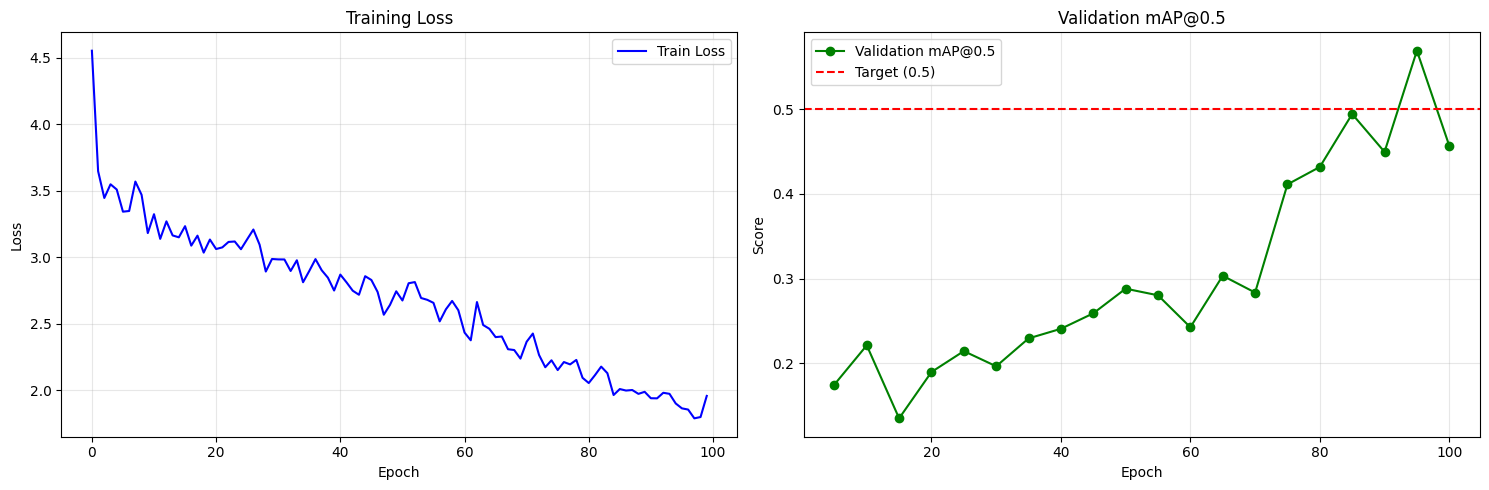

Loading Best Model for Test Evaluation...

EXPERIMENT SUMMARY (For Report)
Model: TinyDETR (ResNet18 + Frozen BN)
Queries: 20
Augmentation: Resize, ColorJitter, Grayscale, Blur, Flip
Epochs: 100
Best Validation mAP@0.5: 0.5688
Final Test mAP@0.5:      0.6055
Avg Time per Epoch:      6.33 sec


In [8]:
# 1. Training Curves (Copy Image for Report)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_history, label='Train Loss', color='blue')
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

epochs_x = [(i+1)*5 for i in range(len(map_history))]
ax[1].plot(epochs_x, map_history, label='Validation mAP@0.5', color='green', marker='o')
ax[1].set_title('Validation mAP@0.5')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Score')
ax[1].axhline(y=0.5, color='r', linestyle='--', label='Target (0.5)')
ax[1].grid(True, alpha=0.3)
ax[1].legend()
plt.tight_layout()
plt.show()

# 2. Final Test Evaluation (Load Best Model)
print("Loading Best Model for Test Evaluation...")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
metric.reset()

with torch.no_grad():
    for images, targets in test_dloader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        pred_list = []
        target_list = []
        for i in range(len(images)):
            probs = outputs['pred_logits'][i].softmax(-1)
            scores = probs[:, 1]
            labels = torch.zeros_like(scores, dtype=torch.long)
            boxes = box_c_to_xy(outputs['pred_boxes'][i])
            orig_h, orig_w = targets[i]['orig_size']
            boxes[:, 0::2] *= orig_w
            boxes[:, 1::2] *= orig_h
            pred_list.append(dict(boxes=boxes, scores=scores, labels=labels))
            
            tgt_boxes = box_c_to_xy(targets[i]['boxes'])
            tgt_boxes[:, 0::2] *= orig_w
            tgt_boxes[:, 1::2] *= orig_h
            tgt_labels = (targets[i]['labels'] - 1).to(device)
            target_list.append(dict(boxes=tgt_boxes, labels=tgt_labels))
        metric.update(pred_list, target_list)

test_res = metric.compute()
test_map = test_res['map_50'].item()

# 3. Experiment Summary (Copy Data for Report Tables)
print("\n" + "="*40)
print("EXPERIMENT SUMMARY (For Report)")
print("="*40)
print(f"Model: TinyDETR (ResNet18 + Frozen BN)")
print(f"Queries: {NUM_QUERIES}")
print(f"Augmentation: Resize, ColorJitter, Grayscale, Blur, Flip")
print(f"Epochs: {EPOCHS}")
print(f"Best Validation mAP@0.5: {best_val_map:.4f}")
print(f"Final Test mAP@0.5:      {test_map:.4f}")
print(f"Avg Time per Epoch:      {total_time/EPOCHS:.2f} sec")
print("="*40)


 ## 6. Qualitative Results (Grid Visualization)

Generating Qualitative Results for Report...


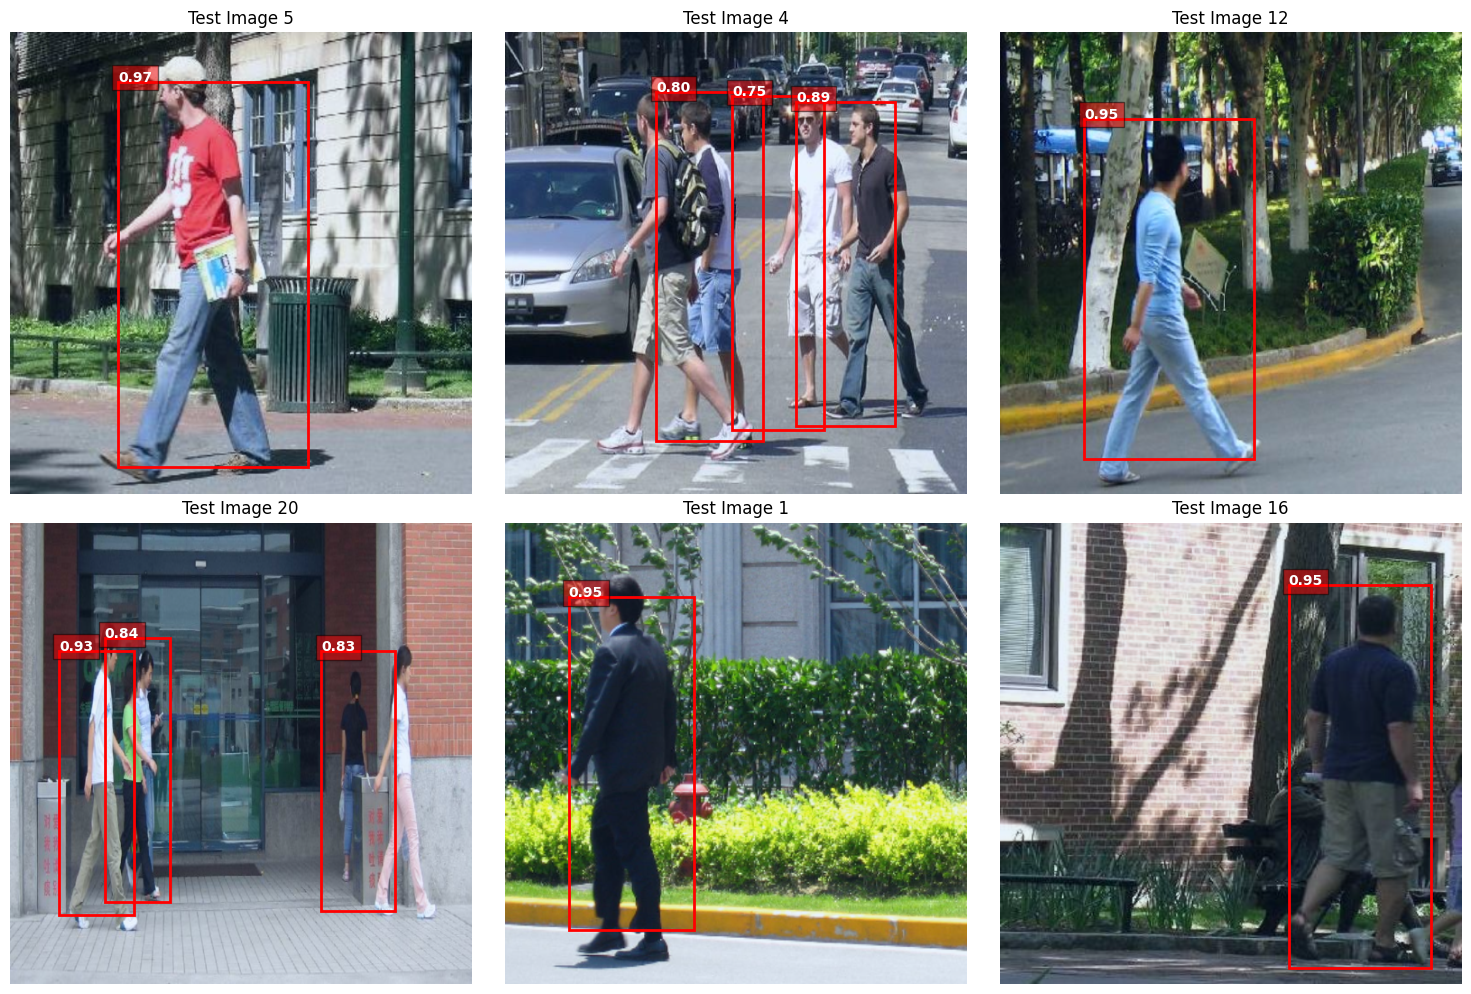

In [11]:
# Visualization Function (Grid of 6 images)
def visualize_grid(model, dataset, num_images=6, threshold=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    # Create grid
    cols = 3
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img_tensor, target = dataset[idx]
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device))
        
        probas = output['pred_logits'].softmax(-1)[0, :, 1]
        boxes = output['pred_boxes'][0]
        
        # Prepare Image
        image_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        h, w, _ = image_np.shape
        
        # Prepare Boxes
        boxes_xyxy = box_c_to_xy(boxes)
        boxes_xyxy[:, 0::2] *= w
        boxes_xyxy[:, 1::2] *= h
        
        # NMS & Threshold
        keep = ops.nms(boxes_xyxy, probas, 0.3)
        keep = keep[probas[keep] > threshold]
        
        # Plot
        axes[i].imshow(image_np)
        for k in keep:
            xmin, ymin, xmax, ymax = boxes_xyxy[k].tolist()
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            axes[i].text(xmin, ymin, f"{probas[k]:.2f}", color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='red', alpha=0.5))
        axes[i].axis('off')
        axes[i].set_title(f"Test Image {idx}")

    plt.tight_layout()
    plt.show()

print("Generating Qualitative Results for Report...")
visualize_grid(model, test_dataset, num_images=6, threshold=0.5)